

## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
import torch
import numpy as np
import PIL

import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

from torchvision import datasets, models, transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)

In [2]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [3]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
!ls /content/gdrive/My\ Drive/Colab\ Notebooks/data

CompleteDataset.csv  journey-springfield.zip


In [5]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/data/journey-springfield.zip -d task


В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [6]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


# Подготовка датасета

Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [7]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        data_transforms = {
            'train': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(hue=.1, saturation=.1),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
            'val_test': transforms.Compose([
                transforms.Resize(size=(RESCALE_SIZE, RESCALE_SIZE)),
                transforms.CenterCrop(200),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ]),
        }

        transform = (data_transforms['train'] if self.mode == 'train' else 
                     data_transforms['val_test'])
        
        x = self.load_sample(self.files[index])
        x = transform(x)
        
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
 

In [8]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

# Получение обучающей выборки


In [9]:
TRAIN_DIR = Path('task/train/simpsons_dataset/')
TEST_DIR = Path('task/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [10]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [11]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

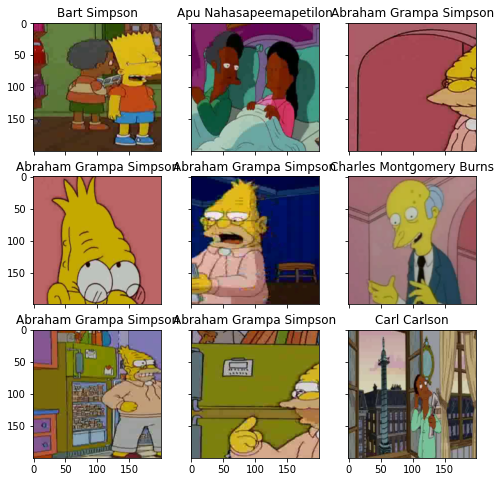

In [12]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети




In [13]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        optimizer.step()

        preds = torch.argmax(outputs, 1)
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [14]:
def eval_epoch(model, val_loader, criterion):
    model.eval()

    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
        
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [15]:
def train(train_files, val_files, model, optimizer, 
          criterion, epochs, batch_size,scheduler):
  
    train_loader = DataLoader(train_dataset, batch_size=batch_size, 
                              shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, 
                            shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, 
                                              criterion, optimizer)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            print("val loss:", val_loss)

            history.append((train_loss, train_acc, val_loss, val_acc))

            scheduler.step()
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, 
                                           v_acc=val_acc))
            
    return history

In [16]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

Запустим обучение сети.

In [17]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [18]:
n_classes = len(np.unique(train_val_labels))

# Дообучим предобученную нейросеть ResNet50

In [22]:
resnet50 = models.resnet50(pretrained=True)

In [24]:
# замораживаем параметры (веса)
for param in resnet50.parameters():
    param.requires_grad = True

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = resnet50.fc.in_features
n_classes = len(np.unique(train_val_labels))

# Заменяем Fully-Connected слой на наш линейный классификатор
resnet50.fc = nn.Linear(num_features, n_classes)
resnet50 = resnet50.to(DEVICE)

# Определяем оптимизатор, критерий
optimizer = optim.AdamW(resnet50.parameters(),lr=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 3, 0.5)

criterion=nn.CrossEntropyLoss()

In [25]:
# запускаем обучение
resnet50_fine = train(train_dataset, val_dataset, model=resnet50, criterion=criterion,
                          epochs=20, batch_size=64, optimizer=optimizer, scheduler=scheduler)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.8715006599682206


epoch:   5%|▌         | 1/20 [03:19<1:03:02, 199.06s/it]

val loss: 0.28853806014000843

Epoch 001 train_loss: 0.8715     val_loss 0.2885 train_acc 0.8008 val_acc 0.9274
loss 0.4092960716930269


epoch:  10%|█         | 2/20 [06:31<59:08, 197.14s/it]

val loss: 0.22226926267615393

Epoch 002 train_loss: 0.4093     val_loss 0.2223 train_acc 0.8936 val_acc 0.9389
loss 0.24900360286323134


epoch:  15%|█▌        | 3/20 [09:42<55:21, 195.36s/it]

val loss: 0.27246377613704353

Epoch 003 train_loss: 0.2490     val_loss 0.2725 train_acc 0.9362 val_acc 0.9329
loss 0.12882350466723533


epoch:  20%|██        | 4/20 [12:51<51:34, 193.40s/it]

val loss: 0.14259557624217703

Epoch 004 train_loss: 0.1288     val_loss 0.1426 train_acc 0.9681 val_acc 0.9666
loss 0.09546581059703782


epoch:  25%|██▌       | 5/20 [16:02<48:09, 192.65s/it]

val loss: 0.13158834627930915

Epoch 005 train_loss: 0.0955     val_loss 0.1316 train_acc 0.9746 val_acc 0.9671
loss 0.08706194836001115


epoch:  30%|███       | 6/20 [19:16<45:02, 193.04s/it]

val loss: 0.12239407877504319

Epoch 006 train_loss: 0.0871     val_loss 0.1224 train_acc 0.9769 val_acc 0.9710
loss 0.04761048704191176


epoch:  35%|███▌      | 7/20 [22:30<41:52, 193.24s/it]

val loss: 0.09641059114755034

Epoch 007 train_loss: 0.0476     val_loss 0.0964 train_acc 0.9885 val_acc 0.9773
loss 0.0350368877554731


epoch:  40%|████      | 8/20 [25:40<38:29, 192.46s/it]

val loss: 0.10059929392112711

Epoch 008 train_loss: 0.0350     val_loss 0.1006 train_acc 0.9913 val_acc 0.9767
loss 0.03685103966607133


epoch:  45%|████▌     | 9/20 [28:49<35:05, 191.38s/it]

val loss: 0.09723778775790883

Epoch 009 train_loss: 0.0369     val_loss 0.0972 train_acc 0.9903 val_acc 0.9809
loss 0.023851255183235772


epoch:  50%|█████     | 10/20 [31:58<31:46, 190.61s/it]

val loss: 0.09346235963371986

Epoch 010 train_loss: 0.0239     val_loss 0.0935 train_acc 0.9941 val_acc 0.9817
loss 0.019569675320585834


epoch:  55%|█████▌    | 11/20 [35:07<28:30, 190.01s/it]

val loss: 0.09679134333611587

Epoch 011 train_loss: 0.0196     val_loss 0.0968 train_acc 0.9954 val_acc 0.9807
loss 0.01725522430895543


epoch:  60%|██████    | 12/20 [38:15<25:16, 189.52s/it]

val loss: 0.09880807403097865

Epoch 012 train_loss: 0.0173     val_loss 0.0988 train_acc 0.9954 val_acc 0.9832
loss 0.014664508406885827


epoch:  65%|██████▌   | 13/20 [41:24<22:04, 189.28s/it]

val loss: 0.09385143044536925

Epoch 013 train_loss: 0.0147     val_loss 0.0939 train_acc 0.9963 val_acc 0.9828
loss 0.012815102426611309


epoch:  70%|███████   | 14/20 [44:33<18:54, 189.12s/it]

val loss: 0.09478457366193425

Epoch 014 train_loss: 0.0128     val_loss 0.0948 train_acc 0.9968 val_acc 0.9830
loss 0.012753156980607179


epoch:  75%|███████▌  | 15/20 [47:41<15:44, 188.83s/it]

val loss: 0.09665076689593023

Epoch 015 train_loss: 0.0128     val_loss 0.0967 train_acc 0.9967 val_acc 0.9820
loss 0.009722024630478441


epoch:  80%|████████  | 16/20 [50:48<12:33, 188.44s/it]

val loss: 0.10108820743916716

Epoch 016 train_loss: 0.0097     val_loss 0.1011 train_acc 0.9973 val_acc 0.9824
loss 0.009190147837695261


epoch:  85%|████████▌ | 17/20 [53:56<09:24, 188.15s/it]

val loss: 0.10030532622824295

Epoch 017 train_loss: 0.0092     val_loss 0.1003 train_acc 0.9975 val_acc 0.9828
loss 0.007469109484412242


epoch:  90%|█████████ | 18/20 [57:03<06:15, 187.89s/it]

val loss: 0.1013463570989421

Epoch 018 train_loss: 0.0075     val_loss 0.1013 train_acc 0.9978 val_acc 0.9836
loss 0.008885866456933582


epoch:  95%|█████████▌| 19/20 [1:00:11<03:07, 187.83s/it]

val loss: 0.10218904812414704

Epoch 019 train_loss: 0.0089     val_loss 0.1022 train_acc 0.9976 val_acc 0.9826
loss 0.007073511723690656


epoch: 100%|██████████| 20/20 [1:03:19<00:00, 189.99s/it]

val loss: 0.10223992110147422

Epoch 020 train_loss: 0.0071     val_loss 0.1022 train_acc 0.9980 val_acc 0.9832


Построим кривые обучения

In [26]:
loss, acc, val_loss, val_acc = zip(*resnet50_fine)

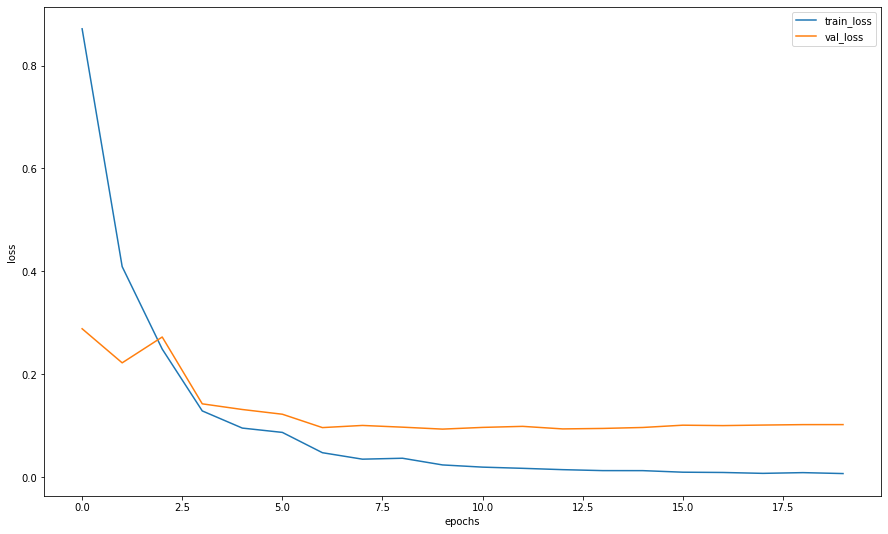

In [27]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [28]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [29]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet50, ex_img.unsqueeze(0))

In [30]:
# прогоняем сеть по всему val_dataset

imgs = [val_dataset[id][0].unsqueeze(0) for id in range(len(val_dataset))]

probs_ims = predict(resnet50, imgs)

In [31]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [32]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in range(len(val_dataset))]

preds_class = [label_encoder.classes_[i] for i in y_pred]

actual_class = [label_encoder.classes_[i] for i in actual_labels]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [33]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(actual_class, preds_class, average='weighted')

0.9816664590662791

In [34]:
f1_score(actual_class, preds_class, average='weighted')

0.9831986768132954

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

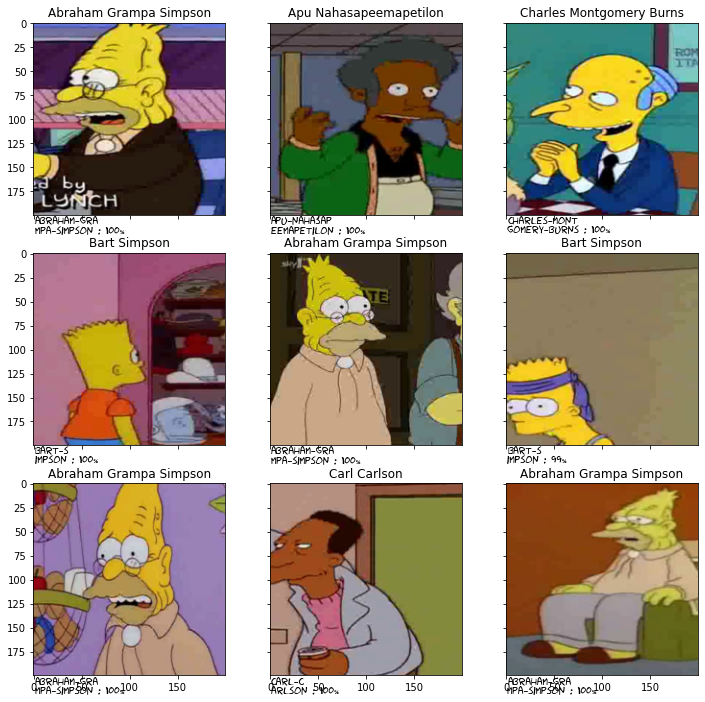

In [35]:


fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 200),120,30,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet50, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 200, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=10, color='black',fontweight='bold')

In [36]:
# количество уникальных предсказанных меток класса на val_dataset
print (len(np.unique(preds_class)))
# общее количество меток класса на train_dataset
print (len(np.unique(train_val_labels)))

42
42


Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

In [37]:
# классы которые не удается распознать сети
for i in np.unique(train_val_labels):
  if i not in np.unique(preds_class):
    print (i)

Как мы видим часть классов из обучающей выборки не удается разпознать нашей сети. Это может быть связано с малым количеством объектов в данных классах. Данную проблемы постараемся решить в дальнейшем. 

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [38]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls task

characters_illustration.png  sample_submission.csv  testset  train


In [39]:
import pandas as pd
my_submit = pd.read_csv("task/sample_submission.csv")
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)


In [40]:
my_submit.to_csv('task/resnet50_4.csv', index=False)

### Final kaggle result = 0.99574, kaggle user = Chetverikov Vladimir

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
